In [1]:
import os
import math
import pandas as pd
import numpy as np
import umap

# Configuration settings
from chasm.config import CONFIG

# PLINK preprocessing utilities
from chasm.plink_preprocessing import (
    test, 
    concat_AFs, 
    divide_into_chunks, 
    make_ids,
    make_AFs
)

from chasm.data_preprocessing import (
    is_snp,
    make_df,
    calculate_AFs,
    merge_AFs_ensembl_build,
    divide_into_chunks,
    align_dataframes,
)
from chasm.gwas import ols_regression, pca_of_n_snps, project_on_dimensions

from chasm.visualization import make_population_plot
from chasm.ld_blocks import segmenter
from chasm.abyss import linear_abyss

from chasm.fst import make_fst, make_global_fst
from chasm.cluster import silhouette_score_clusters

2025-02-17 19:12:14.774857: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 19:12:14.831660: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 19:12:15.295862: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-17 19:12:15.297944: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 19:12:16.312527: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
# Changing the GTM data into a pickle file having an id file and calculating the AFs for each SNP 
# with the CHROM:POS for every corresponding RSID

# GTM data
"""
path_data_raw = f"{CONFIG['PATH_data']}/00_raw/recoded_1000G.raw"
path_raw = f"{CONFIG['PATH_data']}/01_raw/"
path_usefull = f"{CONFIG['PATH_data']}/02_usefull/"

geno = make_df(path_data_raw, path_usefull, path_raw)

afs = calculate_AFs(geno)

path_ensembl = f"/mnt/e/1000G_data/usefull/ensembl_build"
merge_AFs_ensembl_build(path_ensembl, path_usefull, afs)
"""
# Divide the AFs into chunks
"""
size_chunck = 20_000
min_maf = 0.01

path_raw = f"{CONFIG['PATH_data']}/01_raw/geno.pkl"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_output = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"

divide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)
"""

'\nsize_chunck = 20_000\nmin_maf = 0.01\n\npath_raw = f"{CONFIG[\'PATH_data\']}/01_raw/geno.pkl"\npath_afs = f"{CONFIG[\'PATH_data\']}/02_usefull/allele_frequencies.pkl"\npath_output = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\n\ndivide_into_chunks(path_raw, path_afs, path_output, size_chunck, min_maf)\n'

# Choose SNPs to project on n dimensions

In [3]:

"""
path_input = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
path_output = f"{CONFIG['PATH_data']}/04_projected/"
nr_of_projected_dimensions = 3
project_on_dimensions(path_input, path_output, nr_of_projected_dimensions)
"""


'\npath_input = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF/"\npath_output = f"{CONFIG[\'PATH_data\']}/04_projected/"\nnr_of_projected_dimensions = 3\nproject_on_dimensions(path_input, path_output, nr_of_projected_dimensions)\n'

# Observe raw dimensions

In [4]:
path_input = f"{CONFIG['PATH_data']}/04_projected/snp_ids.pkl"
pd.read_pickle(path_input)

,pval,betas,snp_rs,-logp,dim
139,1.770881e-82,-10.566159,rs10803434_A,81.751811,1
689,9.291462e-80,-10.435182,rs11802371_G,79.031916,1
18,1.158522e-67,9.686547,rs12743883_G,66.936096,1
321,1.249945e-65,-9.512141,rs4424509_G,64.903109,1
0,2.957019e-65,9.584452,rs3928804_T,64.529146,1
...,...,...,...,...,...
84,8.830340e-01,-0.042491,rs5769852_C,0.054023,3
7,8.906630e-01,-0.039375,rs1894252_A,0.050287,3
103,9.102854e-01,0.035420,rs1974458_G,0.040822,3
77,9.535662e-01,0.016828,rs135972_G,0.020649,3


In [5]:
path_input = f"{CONFIG['PATH_data']}/04_projected/"
path_afs = f"{CONFIG['PATH_data']}/02_usefull/allele_frequencies.pkl"
path_ids = f"{CONFIG['PATH_data']}/02_usefull/ids.pkl"
path_panel = f"{CONFIG['PATH_data']}/00_raw/all.panel"
ids = pd.read_pickle(path_ids)
labels = pd.read_pickle(path_panel)
merged_df = ids.merge(labels, left_on="IID", right_on="Sample name")
dims = [f for f in os.listdir(path_input) if f.startswith("dim")]
for dim in dims:
    path_dim = f"{path_input}/{dim}"
    PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
    path_PC = f"{path_dim}/{PCs}"
    PC_dim = pd.read_pickle(path_PC)
    merged_df[dim] = PC_dim['PC1']
    

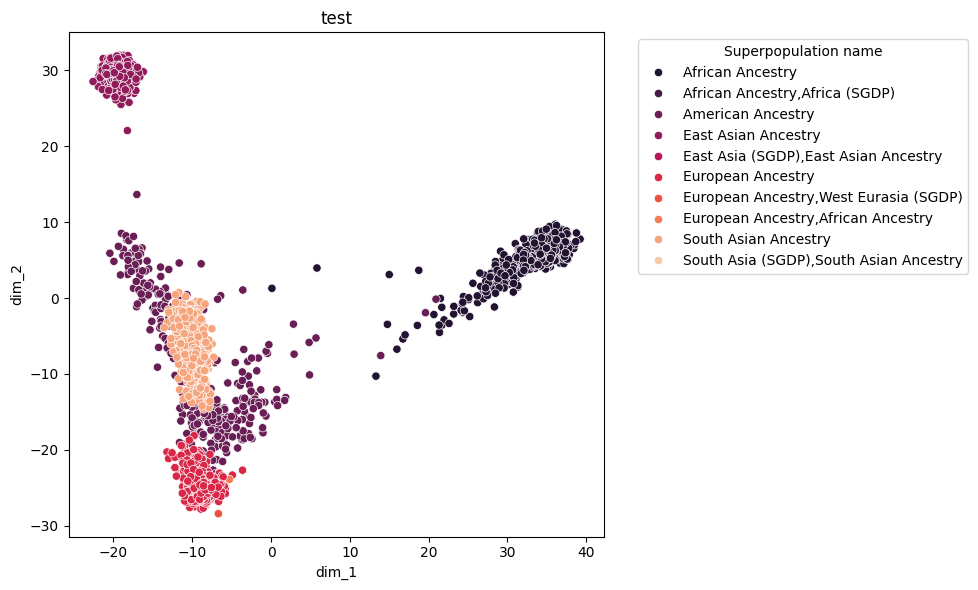

In [6]:
make_population_plot(merged_df, 'dim_1', 'dim_2', 'Superpopulation name', 'test', palette = 'rocket')

In [7]:
"""
labels = silhouette_score_clusters(merged_df, ['dim_1', 'dim_2', 'dim_3'], plot=False)
merged_df['clusters'] = labels
make_population_plot(merged_df, 'dim_1', 'dim_2', 'clusters', 'test', palette = 'rocket')
merged_df.to_pickle(f"{CONFIG['PATH_data']}/04_projected/samples_with_clusters.pkl")
"""

'\nlabels = silhouette_score_clusters(merged_df, [\'dim_1\', \'dim_2\', \'dim_3\'], plot=False)\nmerged_df[\'clusters\'] = labels\nmake_population_plot(merged_df, \'dim_1\', \'dim_2\', \'clusters\', \'test\', palette = \'rocket\')\nmerged_df.to_pickle(f"{CONFIG[\'PATH_data\']}/04_projected/samples_with_clusters.pkl")\n'

In [8]:
# Divide into chunks
"""
path_input  = f"{CONFIG['PATH_data']}/03_macro_similar_AF"
for cluster in list(merged_df['clusters'].unique()):
    cluster_df = merged_df[merged_df['clusters'] == cluster]
    for chrom in [f for f in os.listdir(path_input) if f.startswith('chrom')]:
        path_chrom = f"{path_input}/{chrom}"
        for chunk in [f for f in os.listdir(path_chrom) if f.startswith('chunk')]:
            path_chunk = f"{path_chrom}/{chunk}"
            chunk_df = pd.read_pickle(path_chunk)
            chunk_df['IID'] = ids['IID']
            merged = pd.merge(cluster_df[['IID']], chunk_df, on='IID')
            merged.drop('IID', axis=1, inplace=True)
            path_output = f"{CONFIG['PATH_data']}/05_macro_similar_per_pop/pop_{cluster}/{chrom}"
            os.makedirs(path_output, exist_ok=True)
            merged.to_pickle(f"{path_output}/{chunk}")
"""

'\npath_input  = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF"\nfor cluster in list(merged_df[\'clusters\'].unique()):\n    cluster_df = merged_df[merged_df[\'clusters\'] == cluster]\n    for chrom in [f for f in os.listdir(path_input) if f.startswith(\'chrom\')]:\n        path_chrom = f"{path_input}/{chrom}"\n        for chunk in [f for f in os.listdir(path_chrom) if f.startswith(\'chunk\')]:\n            path_chunk = f"{path_chrom}/{chunk}"\n            chunk_df = pd.read_pickle(path_chunk)\n            chunk_df[\'IID\'] = ids[\'IID\']\n            merged = pd.merge(cluster_df[[\'IID\']], chunk_df, on=\'IID\')\n            merged.drop(\'IID\', axis=1, inplace=True)\n            path_output = f"{CONFIG[\'PATH_data\']}/05_macro_similar_per_pop/pop_{cluster}/{chrom}"\n            os.makedirs(path_output, exist_ok=True)\n            merged.to_pickle(f"{path_output}/{chunk}")\n'

In [9]:
# iteration 1

In [10]:

"""
path_input = f"{CONFIG['PATH_data']}/05_macro_similar_per_pop/"
path_output = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
    path_input_pop = f"{path_input}/{pop}"
    path_output_pop = f"{path_output}/{pop}"
    nr_of_projected_dimensions = 3
    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)
"""

'\npath_input = f"{CONFIG[\'PATH_data\']}/05_macro_similar_per_pop/"\npath_output = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\nfor pop in [f for f in os.listdir(path_input) if f.startswith(\'pop\')]:\n    path_input_pop = f"{path_input}/{pop}"\n    path_output_pop = f"{path_output}/{pop}"\n    nr_of_projected_dimensions = 3\n    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)\n'

In [11]:
"""
merged_df = pd.read_pickle(f"{CONFIG['PATH_data']}/04_projected/samples_with_clusters.pkl")
path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
pops = [f for f in os.listdir(path_input) if f.startswith('pop')]
for pop in pops:
    pop = int(pop.split('_')[1])
    temp_samples = merged_df[merged_df['clusters'] == pop].copy()
    path_pop = f"{path_input}/pop_{pop}"
    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]
    for dim in dims:
        path_dim = f"{path_pop}/{dim}"
        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
        path_PC = f"{path_dim}/{PCs}"
        PC_dim = pd.read_pickle(path_PC)
        temp_samples[dim] = list(PC_dim['PC1'])
    
    make_population_plot(temp_samples, 'dim_1', 'dim_2', 'Population name', 'test', palette = 'rocket')
    
    # clustering
    labels = silhouette_score_clusters(temp_samples, ['dim_1', 'dim_2', 'dim_3'], plot=False)
    temp_samples['clusters'] = labels
    temp_samples.to_pickle(f"{CONFIG['PATH_data']}/06_projected_per_pop/pop_{pop}/samples_with_clusters.pkl")
    make_population_plot(temp_samples, 'dim_1', 'dim_2', 'clusters', 'test', palette = 'rocket')
"""

'\nmerged_df = pd.read_pickle(f"{CONFIG[\'PATH_data\']}/04_projected/samples_with_clusters.pkl")\npath_input = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\npops = [f for f in os.listdir(path_input) if f.startswith(\'pop\')]\nfor pop in pops:\n    pop = int(pop.split(\'_\')[1])\n    temp_samples = merged_df[merged_df[\'clusters\'] == pop].copy()\n    path_pop = f"{path_input}/pop_{pop}"\n    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]\n    for dim in dims:\n        path_dim = f"{path_pop}/{dim}"\n        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]\n        path_PC = f"{path_dim}/{PCs}"\n        PC_dim = pd.read_pickle(path_PC)\n        temp_samples[dim] = list(PC_dim[\'PC1\'])\n    \n    make_population_plot(temp_samples, \'dim_1\', \'dim_2\', \'Population name\', \'test\', palette = \'rocket\')\n    \n    # clustering\n    labels = silhouette_score_clusters(temp_samples, [\'dim_1\', \'dim_2\', \'dim_3\'], plot=False)\n    temp_samples[\

In [12]:
"""
path_input_macro  = f"{CONFIG['PATH_data']}/03_macro_similar_AF"
path_input = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
pops = [f for f in os.listdir(path_input) if f.startswith('pop')]
for pop in pops:
    pop_nr = int(pop.split('_')[1])
    path_pop = f"{path_input}/{pop}"
    samples = pd.read_pickle(f"{path_pop}/samples_with_clusters.pkl")
    for cluster in list(samples['clusters'].unique()):
        cluster_df = samples[samples['clusters'] == cluster]
        
        for chrom in [f for f in os.listdir(path_input_macro) if f.startswith('chrom')]:
            path_chrom = f"{path_input_macro}/{chrom}"
            for chunk in [f for f in os.listdir(path_chrom) if f.startswith('chunk')]:
                path_chunk = f"{path_chrom}/{chunk}"
                chunk_df = pd.read_pickle(path_chunk)
                chunk_df['IID'] = ids['IID']
                merged = pd.merge(cluster_df[['IID']], chunk_df, on='IID')
                merged.drop('IID', axis=1, inplace=True)
                path_output = f"{CONFIG['PATH_data']}/07_macro_similar_per_sub_pop/pop_{pop_nr}_subpop_{cluster}/{chrom}"
                os.makedirs(path_output, exist_ok=True)
                merged.to_pickle(f"{path_output}/{chunk}")
                
"""

'\npath_input_macro  = f"{CONFIG[\'PATH_data\']}/03_macro_similar_AF"\npath_input = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\npops = [f for f in os.listdir(path_input) if f.startswith(\'pop\')]\nfor pop in pops:\n    pop_nr = int(pop.split(\'_\')[1])\n    path_pop = f"{path_input}/{pop}"\n    samples = pd.read_pickle(f"{path_pop}/samples_with_clusters.pkl")\n    for cluster in list(samples[\'clusters\'].unique()):\n        cluster_df = samples[samples[\'clusters\'] == cluster]\n        \n        for chrom in [f for f in os.listdir(path_input_macro) if f.startswith(\'chrom\')]:\n            path_chrom = f"{path_input_macro}/{chrom}"\n            for chunk in [f for f in os.listdir(path_chrom) if f.startswith(\'chunk\')]:\n                path_chunk = f"{path_chrom}/{chunk}"\n                chunk_df = pd.read_pickle(path_chunk)\n                chunk_df[\'IID\'] = ids[\'IID\']\n                merged = pd.merge(cluster_df[[\'IID\']], chunk_df, on=\'IID\')\n                merged

In [13]:
"""
path_input = f"{CONFIG['PATH_data']}/07_macro_similar_per_sub_pop/"
path_output = f"{CONFIG['PATH_data']}/08_projected_per_sub_pop/"
for pop in [f for f in os.listdir(path_input) if f.startswith('pop')]:
    path_input_pop = f"{path_input}/{pop}"
    path_output_pop = f"{path_output}/{pop}"
    nr_of_projected_dimensions = 3
    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)
    
"""

'\npath_input = f"{CONFIG[\'PATH_data\']}/07_macro_similar_per_sub_pop/"\npath_output = f"{CONFIG[\'PATH_data\']}/08_projected_per_sub_pop/"\nfor pop in [f for f in os.listdir(path_input) if f.startswith(\'pop\')]:\n    path_input_pop = f"{path_input}/{pop}"\n    path_output_pop = f"{path_output}/{pop}"\n    nr_of_projected_dimensions = 3\n    project_on_dimensions(path_input_pop, path_output_pop, nr_of_projected_dimensions)\n    \n'

In [7]:
"""
path_propjected = f"{CONFIG['PATH_data']}/06_projected_per_pop/"
path_input = f"{CONFIG['PATH_data']}/08_projected_per_sub_pop/"
pops = [f for f in os.listdir(path_input) if f.startswith('pop')]
for pop in pops:

    sub_pop = int(pop.split('_')[3])
    pop = int(pop.split('_')[1])
    
    path_propjected_pop = f"{path_propjected}/pop_{pop}"
    merged_df = pd.read_pickle(f"{path_propjected_pop}/samples_with_clusters.pkl")
    temp_samples = merged_df[merged_df['clusters'] == sub_pop].copy()
    path_pop = f"{path_input}/pop_{pop}_subpop_{sub_pop}"
    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]
    for dim in dims:
        path_dim = f"{path_pop}/{dim}"
        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]
        path_PC = f"{path_dim}/{PCs}"
        PC_dim = pd.read_pickle(path_PC)
        temp_samples[dim] = list(PC_dim['PC1'])
    
    make_population_plot(temp_samples, 'dim_3', 'dim_2', 'Population name', 'test', palette = 'rocket')
"""

'\npath_propjected = f"{CONFIG[\'PATH_data\']}/06_projected_per_pop/"\npath_input = f"{CONFIG[\'PATH_data\']}/08_projected_per_sub_pop/"\npops = [f for f in os.listdir(path_input) if f.startswith(\'pop\')]\nfor pop in pops:\n\n    sub_pop = int(pop.split(\'_\')[3])\n    pop = int(pop.split(\'_\')[1])\n    \n    path_propjected_pop = f"{path_propjected}/pop_{pop}"\n    merged_df = pd.read_pickle(f"{path_propjected_pop}/samples_with_clusters.pkl")\n    temp_samples = merged_df[merged_df[\'clusters\'] == sub_pop].copy()\n    path_pop = f"{path_input}/pop_{pop}_subpop_{sub_pop}"\n    dims = [f for f in os.listdir(path_pop) if f.startswith("dim")]\n    for dim in dims:\n        path_dim = f"{path_pop}/{dim}"\n        PCs = [f for f in os.listdir(path_dim) if f.startswith("global")][0]\n        path_PC = f"{path_dim}/{PCs}"\n        PC_dim = pd.read_pickle(path_PC)\n        temp_samples[dim] = list(PC_dim[\'PC1\'])\n    \n    make_population_plot(temp_samples, \'dim_3\', \'dim_2\', \'Populat

# Find perfect MAF prediction

In [16]:
path_input = f"{CONFIG['PATH_data']}/03_macro_similar_AF/"
for chrom in [f for f in  os.listdir(path_input) if f.startswith('chrom')][0:1]:
    path_chrom = f"{path_input}/{chrom}"
    for chunk in [f for f in os.listdir(path_chrom) if f.startswith('chunk')][0:1]:
        path_chunk = f"{path_chrom}/{chunk}"
        chunk_df = pd.read_pickle(path_chunk)
        for snp in list(chunk_df.columns)[0:3]:
            print(f"yey {snp}")
            if is_snp(snp):
                print(snp)
                


yey rs3928804_T
rs3928804_T
yey rs6695244_A
rs6695244_A
yey rs12745158_G
rs12745158_G


In [21]:
folders = os.listdir(f"{CONFIG['PATH_data']}")
projected_folders = [folder for folder in folders if "projected" in folder]
projected_folders
for folder in projected_folders:
    path_projected = f"{CONFIG['PATH_data']}/{folder}"
    print(os.listdir(path_projected))


['pop_0']
['pop_1', 'pop_4', 'pop_0', 'pop_2', 'pop_3']
['pop_1_subpop_0', 'pop_1_subpop_3', 'pop_1_subpop_1', 'pop_1_subpop_2', 'pop_4_subpop_1', 'pop_4_subpop_0', 'pop_0_subpop_2', 'pop_0_subpop_0', 'pop_0_subpop_1', 'pop_2_subpop_2', 'pop_2_subpop_0', 'pop_2_subpop_1', 'pop_3_subpop_2', 'pop_3_subpop_4', 'pop_3_subpop_3', 'pop_3_subpop_0', 'pop_3_subpop_1']


In [ ]:
for snp in list(chunk_df.columns):
    

['rs3928804_T',
 'rs6695244_A',
 'rs12745158_G',
 'rs3010023_A',
 'rs703115_C',
 'rs7516288_A',
 'rs6704281_T',
 'rs10888929_T',
 'rs10801960_A',
 'rs7547336_G',
 'rs2280993_T',
 'rs1891241_A',
 'rs814346_A',
 'rs2816190_C',
 'rs950302_G',
 'rs7538638_T',
 'rs57077193_A',
 'rs1539181_C',
 'rs12743883_G',
 'rs6698901_G',
 'rs6688431_C',
 'rs2864844_G',
 'rs74967713_T',
 'rs10802908_T',
 'rs632832_A',
 'rs2861812_C',
 'rs732285_A',
 'rs6588052_A',
 'rs6425497_T',
 'rs3117747_C',
 'rs1621023_G',
 'rs6426169_G',
 'rs10800366_T',
 'rs10874885_C',
 'rs34067653_T',
 'rs492353_T',
 'rs984222_C',
 'rs7544500_C',
 'rs4427416_C',
 'rs2453244_T',
 'rs2369815_A',
 'rs4553185_T',
 'rs6701779_T',
 'rs74527953_A',
 'rs270487_G',
 'rs867435_T',
 'rs1779961_A',
 'rs34781210_G',
 'rs3010763_T',
 'rs3014216_A',
 'rs9426878_C',
 'rs2369406_C',
 'rs7540629_C',
 'rs145108744_T',
 'rs1354060_G',
 'rs203854_G',
 'rs4319365_G',
 'rs2748680_T',
 'rs1173665_G',
 'rs1933625_C',
 'rs6691165_A',
 'rs4845765_T',
 'rs

In [10]:
chunk_df

,rs3928804_T,rs6695244_A,rs12745158_G,rs3010023_A,rs703115_C,rs7516288_A,rs6704281_T,rs10888929_T,rs10801960_A,rs7547336_G,...,rs115175163_T,rs79431368_G,rs370241406_G,rs548922784_T,rs3845608_G,rs545827664_G,rs555927498_T,rs17116969_G,rs79770347_A,rs539946677_G
0,0,0,1,-1,-1,0,0,-1,1,1,...,0,1,1,1,1,0,1,1,1,1
1,0,0,-1,1,0,-1,0,-1,0,-1,...,1,1,1,1,1,1,1,1,1,1
2,0,1,1,1,0,-1,1,0,1,1,...,1,0,1,1,1,1,1,1,1,1
3,0,-1,-1,0,-1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,0,1,0,0,-1,-1,0,1,-1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,-1,-1,-1,0,0,-1,0,0,-1,0,...,1,1,1,1,1,1,1,1,1,1
2500,1,1,0,1,0,1,0,1,-1,0,...,0,1,1,1,1,1,1,1,1,1
2501,0,1,0,1,1,1,0,0,0,0,...,1,1,1,1,1,0,1,1,0,1
2502,0,1,-1,1,-1,0,-1,0,-1,0,...,1,1,1,1,1,1,1,1,1,1
